In [1]:
import os
import sys
import pickle

import math
from datetime import timezone, datetime

import joblib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
from timescaledb_util import TimeScaleDBUtil

# TimescaleDB用のユーティリティライブラリの設定
_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

# ドルバー読み込み用の関数
def load_dollarbar(table_str, from_str, to_str, fee):
    _sql = f"SELECT * FROM \"{table_str}\" WHERE datetime >= '{from_str}' AND datetime < '{to_str}' ORDER BY dollar_cumsum ASC"
    df = _dbutil.read_sql_query(sql = _sql)
    df['fee'] = fee
    df = df[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']]
    df.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']
    df = df.set_index("Datetime")    
    return df

# 全区間のドルバーの読み込みと保存
df = load_dollarbar('ftx_btc-perp_dollarbar_5000000', '2021-01-01 00:00:00.000+00', '2023-01-01 00:00:00.000+00', 0.02/100)
df.to_pickle('df_ohlcv.pkl')

In [3]:
# Richmanbtcさんのチュートリアルから拝借した関数群

@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

def calc_buysell(df, pips = 1, atr_mux = 0.5, atr_range=14):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_range)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0,  alternative='greater')
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None, buy_entry=None, sell_entry=None, buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

In [4]:
# Richmanbtcさんのチュートリアルの関数をカスタムした関数群

def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
        
    # ドルバー由来の特徴量を追加
    df['TIME'] = df.index
    df['DELTA_TIME'] = df['TIME'].diff()
    df['DELTA_TIME'] = df['DELTA_TIME'].view(int) / 1_000_000_000 # 単位は秒
    df['DELTA_TIME_T-1'] = df['DELTA_TIME'].shift(1)
    df['DELTA_TIME_T-2'] = df['DELTA_TIME'].shift(2)
    df['DELTA_TIME_T-3'] = df['DELTA_TIME'].shift(3)
    df['DELTA_TIME_T-4'] = df['DELTA_TIME'].shift(4)
    
    df['DELTA_TIME_T-1/T'] = df['DELTA_TIME_T-1'] / df['DELTA_TIME']
    df['DELTA_TIME_T-2/T'] = df['DELTA_TIME_T-2'] / df['DELTA_TIME']
    df['DELTA_TIME_T-3/T'] = df['DELTA_TIME_T-3'] / df['DELTA_TIME']
    df['DELTA_TIME_T-4/T'] = df['DELTA_TIME_T-4'] / df['DELTA_TIME']
    
    df['BUY_RATIO'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['BUY_RATIO_T-1'] = df['BUY_RATIO'].shift(1)
    df['BUY_RATIO_T-2'] = df['BUY_RATIO'].shift(2)
    df['BUY_RATIO_T-3'] = df['BUY_RATIO'].shift(3)
    df['BUY_RATIO_T-4'] = df['BUY_RATIO'].shift(4)

    df['SELL_RATIO'] = df['dollar_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['SELL_RATIO_T-1'] = df['SELL_RATIO'].shift(1)
    df['SELL_RATIO_T-2'] = df['SELL_RATIO'].shift(2)
    df['SELL_RATIO_T-3'] = df['SELL_RATIO'].shift(3)
    df['SELL_RATIO_T-4'] = df['SELL_RATIO'].shift(4)

    df['LIQUIDATION_BUY_RATIO'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO_T-1'] = df['LIQUIDATION_BUY_RATIO'].shift(1)
    df['LIQUIDATION_BUY_RATIO_T-2'] = df['LIQUIDATION_BUY_RATIO'].shift(2)
    df['LIQUIDATION_BUY_RATIO_T-3'] = df['LIQUIDATION_BUY_RATIO'].shift(3)
    df['LIQUIDATION_BUY_RATIO_T-4'] = df['LIQUIDATION_BUY_RATIO'].shift(4)

    df['LIQUIDATION_SELL_RATIO'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_SELL_RATIO_T-1'] = df['LIQUIDATION_SELL_RATIO'].shift()
    df['LIQUIDATION_SELL_RATIO_T-2'] = df['LIQUIDATION_SELL_RATIO'].shift(2)
    df['LIQUIDATION_SELL_RATIO_T-3'] = df['LIQUIDATION_SELL_RATIO'].shift(3)
    df['LIQUIDATION_SELL_RATIO_T-4'] = df['LIQUIDATION_SELL_RATIO'].shift(4)
    
    return df.dropna()
from tqdm import tqdm

# 損切、利確指値と高値、安値の系列から、損切と利確が行われるポイントを探索する関数
#@numba.njit # デバッグprintがあるので今はnumbaの高速化を使わないでおく
def calc_ptsl_price(executed=None, horizon=None, entry_price=None, pt_price=None, sl_price=None, low=None, high=None, pips=None, debug=False):
    y = entry_price.copy()
    y[:] = np.nan
    exit_time = entry_price.copy()
    exit_time[:] = np.nan
    for i in range(entry_price.size):
        # インデックスiの次のバーでエントリー指値が刺さっていなかったら、利確損切の結果を探索しない
        if executed[i] == 0:
            y[i] = entry_price[i]
            exit_time[i] = 0
            continue
        
        for j in range(i + 1 + horizon, entry_price.size):
            if debug is True:
                print(f'i {i}, j {j}, entry {entry_price[i]}, pt {pt_price[i]}, sl {sl_price[i]}, low {low[j]}, high {high[j]}')
            if round(low[j] / pips) < round(pt_price[i] / pips) and round(high[j] / pips) > round(pt_price[i] / pips):
                y[i] = pt_price[i]
                exit_time[i] = j - i
                if debug is True:
                    print(f'take profit')
                break
            if round(low[j] / pips) < round(sl_price[i] / pips) and round(high[j] / pips) > round(sl_price[i] / pips):
                y[i] = sl_price[i]
                exit_time[i] = j - i
                if debug is True:
                    print(f'stop loss')
                break
    return y, exit_time

# 損切り利確がある執行を模擬する関数
def calc_buysell_ptsl(df, pips = 1, atr_mux = 0.5, atr_range=14):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_range)
    df.dropna(inplace=True)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、エントリー指値を出します
    # さらに、買い指値と売り指値から両側にlimit_price_dist*2だけ離れたところに、利確指値と損切指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist    
    df['buy_pt_price'] = df['buy_price'] + limit_price_dist * 2
    df['buy_sl_price'] = df['buy_price'] - limit_price_dist * 2
    df['sell_price'] = df['Close'] + limit_price_dist
    df['sell_pt_price'] = df['sell_price'] - limit_price_dist * 2
    df['sell_sl_price'] = df['sell_price'] + limit_price_dist * 2
    
    # エントリー指値が約定したかどうかをデータフレームに追加します (0.0か1.0)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上でないと、一本の足の中で常に有利な購入即売却をしたとみなすので1以上である必要があります)
    fee = df['fee'] # maker手数料

    # 買いエグジット価格の計算
    df['buy_exit_price'], df['buy_fet'] = calc_ptsl_price(
        executed = df['buy_executed'].values,
        horizon = horizon,
        entry_price = df['buy_price'].values,
        pt_price = df['buy_pt_price'].values,
        sl_price = df['buy_sl_price'].values,
        low = df['Low'].values,
        high = df['High'].values,
        pips=pips,
        debug=False
    )

    # calc_ptsl_priceも、calc_force_entry_priceと同様に入力と出力をマイナスにすれば売りエグジット価格の計算に使えます
    df['sell_exit_price'], df['sell_fet'] = calc_ptsl_price(
        executed = df['sell_executed'].values,
        horizon = horizon,
        entry_price = -df['sell_price'].values,
        pt_price = -df['sell_pt_price'].values,
        sl_price = -df['sell_sl_price'].values,
        low = -df['High'].values,
        high = -df['Low'].values,
        pips=pips,
        debug = False
    )
    df['sell_exit_price'] *= -1
            
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['buy_exit_price'] / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['sell_exit_price'] / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

In [5]:
from sklearn.metrics import mean_squared_error

# パフォーマンスを表示するためのユーティリティ関数
def display_performance(df, subtitle):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
    df['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax[0, 0])
    df['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax[0, 0])
    ax[0, 0].set_title(f'Execution probability ({subtitle})')
    ax[0, 0].legend()

    df['buy_fet'].rolling(1000).mean().plot(label='Buy', ax=ax[0, 1])
    df['sell_fet'].rolling(1000).mean().plot(label='Sell',  ax=ax[0, 1])
    ax[0, 1].set_title(f'Average time until exit ({subtitle})')
    ax[0, 1].legend()

    df['buy_fet'].hist(alpha=0.3, label='Buy', ax=ax[1, 0])
    df['sell_fet'].hist(alpha=0.3, label='Sell', ax=ax[1, 0])
    ax[1, 0].set_title(f'Time distribution until exit ({subtitle})')
    ax[1, 0].legend()

    (df['buy_executed'] * df['y_buy']).cumsum().plot(label='Buy', ax=ax[1, 1])
    (df['sell_executed'] * df['y_sell']).cumsum().plot(label='Sell', ax=ax[1, 1])
    (df['buy_executed'] * df['y_buy'] + df['sell_executed'] * df['y_sell']).cumsum().plot(label='Buy+Sell', ax=ax[1, 1])
    ax[1, 1].set_title(f'Cumulative return ({subtitle})')
    ax[1, 1].legend()
    fig.show()
    
    # 数値を表示する
    buy_return = (df["buy_executed"] * df["y_buy"]).sum()
    sell_return = (df["sell_executed"] * df["y_sell"]).sum()
    
    bar_count = len(df)
    
    buy_count = len(df[(df["buy_executed"] > 0)])
    sell_count = len(df[(df["sell_executed"] > 0)])
    
    positive_buy_count = len(df[(df["buy_executed"] > 0) & (df["y_buy"] > 0)])
    negative_buy_count = len(df[(df["buy_executed"] > 0) & (df["y_buy"] < 0)])
    
    positive_sell_count = len(df[(df["sell_executed"] > 0) & (df["y_sell"] > 0)])
    negative_sell_count = len(df[(df["sell_executed"] > 0) & (df["y_sell"] < 0)])

    positive_buy_return = df.loc[(df["buy_executed"] > 0) & (df["y_buy"] > 0), "y_buy"].sum()
    negative_buy_return = df.loc[(df["buy_executed"] > 0) & (df["y_buy"] < 0), "y_buy"].sum()
                           
    positive_sell_return = df.loc[(df["sell_executed"] > 0) & (df["y_sell"] > 0), "y_sell"].sum()
    negative_sell_return = df.loc[(df["sell_executed"] > 0) & (df["y_sell"] < 0), "y_sell"].sum()

    print(f'バーの数 {bar_count}本')
    print(f'買いリターン合計 {buy_return * 100:.2f}% 売りリターン合計 {sell_return*100:.2f}% 合計リターン {(buy_return + sell_return)*100:.2f}%')
    print(f'買い {buy_count}回, 売り {sell_count}回')
    print(f'リターンが正の買い {positive_buy_count}回 ({(positive_buy_count / buy_count)*100:.02f} %), リターンが負の買い {negative_buy_count}回 ({(negative_buy_count / buy_count)*100:.02f} %)')
    print(f'リターンが正の売り {positive_sell_count}回 ({(positive_sell_count / sell_count)*100:.02f} %), リターンが負の売り {negative_sell_count}回 ({(negative_sell_count / sell_count)*100:.02f} %)')
    print(f'正の買いリターン平均 {positive_buy_return / positive_buy_count * 100:.03f} %, 負の買いリターン平均 {negative_buy_return / negative_buy_count * 100:.03f} %')
    print(f'正の売りリターン平均 {positive_sell_return / positive_sell_count * 100:.03f} %, 負の売りリターン平均 {negative_sell_return / negative_sell_count * 100:.03f} %')
    print(f'買いリターン平均 {(buy_return / buy_count)*100:.03f} %, 売りリターン平均 {(sell_return / sell_count)*100:.03f} %')

# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(9):
        _df = df[(df['pred'] >= pred_min + pred_std*i) & (df['pred'] >= pred_min + pred_std*(i+1))]
        pred_sections.append(pred_min + pred_std*i)
        true_means.append(_df['true'].mean())

    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    ax[0, 0].scatter(df.loc[df['true'] != 0, 'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='pre')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])

    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    
    ax[1, 1].remove()
    
    fig.show()

# バックテスト結果を表示するためのユーティリティ関数
def display_backtest(df):
    # バックテストで累積リターンと、ポジションを計算
    df['cum_ret'], df['poss'] = backtest(
        cl = df['Close'].values,
        buy_entry = df['y_pred_buy'].values > 0,
        sell_entry = df['y_pred_sell'].values > 0,
        buy_cost = df['buy_cost'].values,
        sell_cost = df['sell_cost'].values)
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    df['cum_ret'].plot(ax = ax[0, 0])
    ax[0, 0].set_title('Cumulative return')

    df['poss'].plot(ax = ax[0, 1])
    ax[0, 1].set_title('Position history')

    df['poss'].rolling(1000).mean().plot(ax = ax[1, 0])
    ax[1, 0].set_title('Position average history')
    
    df['poss'].diff(1).abs().dropna().cumsum().plot(ax = ax[1, 1])
    ax[1, 1].set_title('Cumulative trade volume')
    fig.show()

    print('t test')
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0, alternative='greater')
    print('t value {}'.format(t))
    print('p value {}'.format(p))

    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))

In [6]:
import optuna
import math

# ATRの指値幅を変数として、取引数とリターンの積を最大化するOptunaの最適化対象の関数
def target_function(x, y):
    df = pd.read_pickle('df_ohlcv.pkl')
    #df = calc_features(df)
    df = calc_buysell(df, pips = 1, atr_mux = x, atr_range=y)
    
    y_buy = (df['buy_executed'] * df['y_buy']).sum()
    y_sell = (df['sell_executed'] * df['y_sell']).sum()
    
    #print(f'y_buy = {y_buy}, y_sell = {y_sell}, atr_mux = {x}, atr_range = {y}')
    return y_buy + y_sell

# Optunaの最適化目的関数
def objective(trial):
    x = trial.suggest_uniform('x', 0.5, 2.0)
    y = trial.suggest_int('y', 14, 14)
    score = target_function(x, y)
    return score

# 最適化を実施
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=400)
#atr_mux = study.best_params['x']
#atr_range = study.best_params['y']
#optuna.visualization.plot_slice(study, params=["x"])

# 以前の学習結果を利用して最適化をスキップ
# 10_000_000ドルバー : Trial 74 finished with value: 16193.839450781088 and parameters: {'x': 1.4788760220633528}. Best is trial 74 with value: 16193.839450781088
# 5_000_000ドルバー : Trial 193 finished with value: 7080.370047388982 and parameters: {'x': 2.1472956042094262}. Best is trial 193 with value: 7080.370047388982.
atr_mux = 1.0
atr_range = 4

バーの数 280290本
買いリターン合計 -1812.29% 売りリターン合計 -1806.45% 合計リターン -3618.75%
買い 38341回, 売り 38633回
リターンが正の買い 18514回 (48.29 %), リターンが負の買い 19826回 (51.71 %)
リターンが正の売り 18970回 (49.10 %), リターンが負の売り 19662回 (50.89 %)
正の買いリターン平均 0.413 %, 負の買いリターン平均 -0.477 %
正の売りリターン平均 0.411 %, 負の売りリターン平均 -0.488 %
買いリターン平均 -0.047 %, 売りリターン平均 -0.047 %


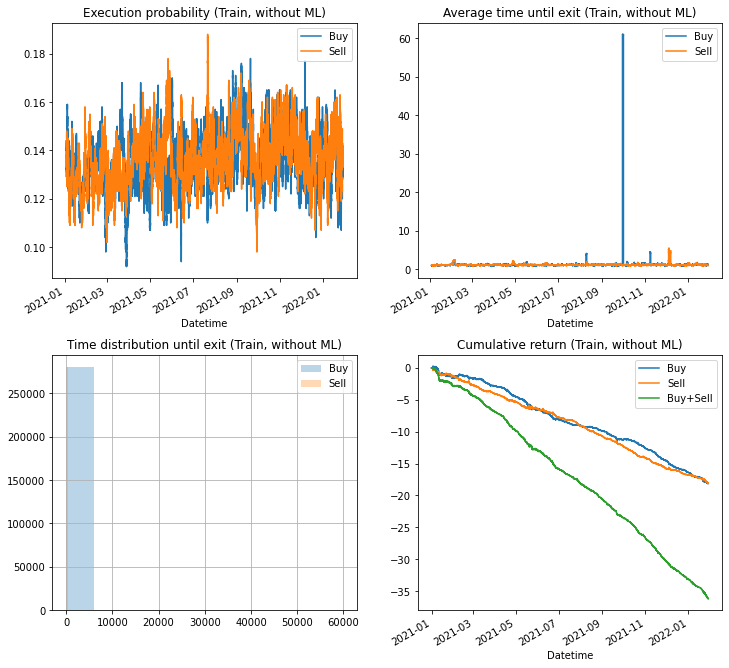

In [7]:
# Optunaの指値幅最適化結果に基づいて、学習区間でのパフォーマンス (MLフィルタ適応前) を表示
df_atr_optimized = pd.read_pickle('df_ohlcv.pkl')
df_atr_optimized = calc_features(df_atr_optimized)
df_atr_optimized = calc_buysell_ptsl(df_atr_optimized, pips = 1, atr_mux = atr_mux, atr_range = atr_range)
#df_atr_optimized = calc_buysell(df_atr_optimized, pips = 1, atr_mux = atr_mux, atr_range = atr_range)

# すべてのバーで売買しようとした結果を表示したいので、全ての行で正のリターンを予測したことにしておく
df_atr_optimized['y_pred_buy'] = 1.0
df_atr_optimized['y_pred_sell'] = 1.0

display_performance(df_atr_optimized, 'Train, without ML')

In [8]:
# データフレームの中身を確認しておく
pd.set_option('max_columns', None)
display(df_atr_optimized[df_atr_optimized['buy_executed'] > 0])
pd.reset_option('max_columns')

,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,fee,TIME,DELTA_TIME,DELTA_TIME_T-1,DELTA_TIME_T-2,DELTA_TIME_T-3,DELTA_TIME_T-4,DELTA_TIME_T-1/T,DELTA_TIME_T-2/T,DELTA_TIME_T-3/T,DELTA_TIME_T-4/T,BUY_RATIO,BUY_RATIO_T-1,BUY_RATIO_T-2,BUY_RATIO_T-3,BUY_RATIO_T-4,SELL_RATIO,SELL_RATIO_T-1,SELL_RATIO_T-2,SELL_RATIO_T-3,SELL_RATIO_T-4,LIQUIDATION_BUY_RATIO,LIQUIDATION_BUY_RATIO_T-1,LIQUIDATION_BUY_RATIO_T-2,LIQUIDATION_BUY_RATIO_T-3,LIQUIDATION_BUY_RATIO_T-4,LIQUIDATION_SELL_RATIO,LIQUIDATION_SELL_RATIO_T-1,LIQUIDATION_SELL_RATIO_T-2,LIQUIDATION_SELL_RATIO_T-3,LIQUIDATION_SELL_RATIO_T-4,ATR,buy_price,buy_pt_price,buy_sl_price,sell_price,sell_pt_price,sell_sl_price,buy_executed,sell_executed,buy_exit_price,buy_fet,sell_exit_price,sell_fet,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:11:12.636000+00:00,29253.0,29306.0,29240.5,29300.5,5.004493e+06,3.441254e+06,1.563239e+06,0.0000,0.0,0.0002,2021-01-01 01:11:12.636000+00:00,7.867,73.285,78.583,0.684,211.038,9.315495,9.988941,0.086945,26.825728,0.687633,0.591686,0.629426,0.503087,0.601383,0.312367,0.408314,0.370574,0.496913,0.398617,0.000000,0.000000,0.000582,0.000000,0.005270,0.0,0.0,0.0,0.0,0.0,66.497779,29234.5,29366.5,29102.5,29366.5,29234.5,29498.5,1.0,0.0,29366.5,3.0,29366.5,0.0,0.004115,0.0,-0.002053,0.0,1.0,1.0
2021-01-01 01:31:12.170000+00:00,29490.5,29528.5,29474.5,29479.0,5.614500e+06,3.062198e+06,2.552302e+06,2989.9638,0.0,0.0002,2021-01-01 01:31:12.170000+00:00,56.450,32.569,30.579,51.972,262.375,0.576953,0.541701,0.920673,4.647919,0.545409,0.707606,0.426650,0.943083,0.520261,0.454591,0.292394,0.573350,0.056917,0.479739,0.000533,0.001769,0.005981,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,59.363854,29420.0,29538.0,29302.0,29538.0,29420.0,29656.0,1.0,0.0,29538.0,3.0,29538.0,0.0,0.003611,0.0,-0.001801,0.0,1.0,1.0
2021-01-01 01:33:07.342000+00:00,29479.0,29491.0,29402.0,29448.0,4.946726e+06,2.352371e+06,2.594355e+06,0.0000,0.0,0.0002,2021-01-01 01:33:07.342000+00:00,115.172,56.450,32.569,30.579,51.972,0.490136,0.282786,0.265507,0.451256,0.475541,0.545409,0.707606,0.426650,0.943083,0.524459,0.454591,0.292394,0.573350,0.056917,0.000000,0.000533,0.001769,0.005981,0.000000,0.0,0.0,0.0,0.0,0.0,66.772891,29381.0,29515.0,29247.0,29515.0,29381.0,29649.0,1.0,0.0,29515.0,2.0,29515.0,0.0,0.004161,0.0,-0.002075,0.0,1.0,1.0
2021-01-01 01:38:58.380000+00:00,29470.0,29550.0,29457.5,29550.0,5.065603e+06,2.950597e+06,2.115006e+06,8737.2594,0.0,0.0002,2021-01-01 01:38:58.380000+00:00,166.951,184.087,115.172,56.450,32.569,1.102641,0.689855,0.338123,0.195081,0.582477,0.454452,0.475541,0.545409,0.707606,0.417523,0.545548,0.524459,0.454591,0.292394,0.001725,0.000000,0.000000,0.000533,0.001769,0.0,0.0,0.0,0.0,0.0,77.653501,29472.0,29628.0,29316.0,29628.0,29472.0,29784.0,1.0,0.0,29316.0,8.0,29628.0,0.0,-0.005693,0.0,-0.002440,0.0,1.0,1.0
2021-01-01 02:12:49.403000+00:00,29443.0,29460.5,29405.0,29425.5,4.998772e+06,1.932064e+06,3.066708e+06,0.0000,0.0,0.0002,2021-01-01 02:12:49.403000+00:00,566.735,280.315,258.736,243.001,238.696,0.494614,0.456538,0.428774,0.421177,0.386508,0.373901,0.546468,0.262834,0.524955,0.613492,0.626099,0.453532,0.737166,0.475045,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,74.551740,29350.5,29500.5,29200.5,29500.5,29350.5,29650.5,1.0,0.0,29200.5,7.0,29500.5,0.0,-0.005511,0.0,-0.002349,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-29 03:34:19.069000+00:00,37711.0,37761.0,37706.0,37743.0,4.697682e+06,2.096759e+06,2.600924e+06,49384.0481,0.0,0.0002,2022-01-29 03:34:19.069000+00:00,215.538,87.529,45.257,6.213,124.138,0.406095,0.209972,0.028826,0.575945,0.446339,0.911966,0.793397,0.

In [ ]:
# Optunaで最適なLightGBM学習パラメータを探して保存する
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation

# 固定するLightGBMのパラメータ
params = {
    'objective':'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'extra_trees': True,
    'deterministic': True,
    'force_row_wise': True
}

# 学習に利用しない特徴量はコメントアウトすること
features = sorted([
    'BUY_RATIO', 'BUY_RATIO_T-1', 'BUY_RATIO_T-2', 'BUY_RATIO_T-3', 'BUY_RATIO_T-4',
    'SELL_RATIO', 'SELL_RATIO_T-1', 'SELL_RATIO_T-2', 'SELL_RATIO_T-3', 'SELL_RATIO_T-4',
    'LIQUIDATION_BUY_RATIO', 'LIQUIDATION_BUY_RATIO_T-1', 'LIQUIDATION_BUY_RATIO_T-2', 'LIQUIDATION_BUY_RATIO_T-3', 'LIQUIDATION_BUY_RATIO_T-4',
    'LIQUIDATION_SELL_RATIO', 'LIQUIDATION_SELL_RATIO_T-1', 'LIQUIDATION_SELL_RATIO_T-2', 'LIQUIDATION_SELL_RATIO_T-3', 'LIQUIDATION_SELL_RATIO_T-4',
    'DELTA_TIME_T-1/T', 'DELTA_TIME_T-2/T', 'DELTA_TIME_T-3/T', 'DELTA_TIME_T-4/T',
])

optuna.logging.set_verbosity(optuna.logging.ERROR)
df = pd.read_pickle('df_ohlcv.pkl')

# トレーニングデータに売買アクションと特徴量を追加
df_train = df[(df.index >= '2021-01-01 00:00:00+00') & (df.index < '2022-01-01 00:00:00+00')].copy()
df_train = calc_features(df_train)
df_train = calc_buysell_ptsl(df_train, pips = 1, atr_mux = atr_mux, atr_range = atr_range)
#df_train = calc_buysell(df_train, pips = 1, atr_mux = atr_mux, atr_range = atr_range)

# バリデーションデータに売買アクションと特徴量を追加
df_validation = df[(df.index >= '2022-01-01 00:00:00+00') & (df.index < '2023-01-01 00:00:00+00')].copy()
df_validation = calc_features(df_validation)
df_validation = calc_buysell_ptsl(df_validation, pips = 1, atr_mux = atr_mux, atr_range = atr_range)
#df_validation = calc_buysell(df_validation, pips = 1, atr_mux = atr_mux, atr_range = atr_range)

# トレーニングデータをLightGBMで使う形式に変換
lgb_buy_train = lgb.Dataset(df_train[features], df_train['y_buy'], free_raw_data=False)
lgb_sell_train = lgb.Dataset(df_train[features], df_train['y_sell'], free_raw_data=False)

# バリデーションデータをLightGBMで使う形式に変換
lgb_buy_validation = lgb.Dataset(df_validation[features], df_validation['y_buy'], reference=lgb_buy_train, free_raw_data=False)
lgb_sell_validation = lgb.Dataset(df_validation[features], df_validation['y_sell'], reference=lgb_sell_train, free_raw_data=False)

# OptunaでのLightGBM最適学習パラメータ探索
model_buy = lgb.train(params,
                      lgb_buy_train,
                      valid_sets=[lgb_buy_validation],
                      early_stopping_rounds = 100,
                      verbose_eval = 0,
                      show_progress_bar = False,
                      optuna_seed = 47)

model_sell = lgb.train(params,
                       lgb_sell_train, valid_sets=[lgb_sell_validation],
                       early_stopping_rounds = 100,
                       verbose_eval = 0,
                       show_progress_bar = False,
                       optuna_seed = 47)


# 最適学習パラメータを保存しておく (次回以降の学習で利用する…かも？)
buy_train_params = model_buy.params.copy()
print(f'Best buy params: {buy_train_params}')
with open('buy_train_params.pkl', 'wb') as f:
    pickle.dump(buy_train_params, f)

sell_train_params = model_sell.params.copy()
print(f'Best sell params: {sell_train_params}')
with open('sell_train_params.pkl', 'wb') as f:
    pickle.dump(sell_train_params, f)

バーの数 257767本
買いリターン合計 1064.38% 売りリターン合計 406.90% 合計リターン 1471.28%
買い 3882回, 売り 954回
リターンが正の買い 2933回 (75.55 %), リターンが負の買い 949回 (24.45 %)
リターンが正の売り 797回 (83.54 %), リターンが負の売り 157回 (16.46 %)
正の買いリターン平均 0.495 %, 負の買いリターン平均 -0.407 %
正の売りリターン平均 0.600 %, 負の売りリターン平均 -0.456 %
買いリターン平均 0.274 %, 売りリターン平均 0.427 %
t test
t value 15.66978694898437
p value 1.290818377807355e-55
p平均法 n = 5
p平均 4.086022158887965e-05


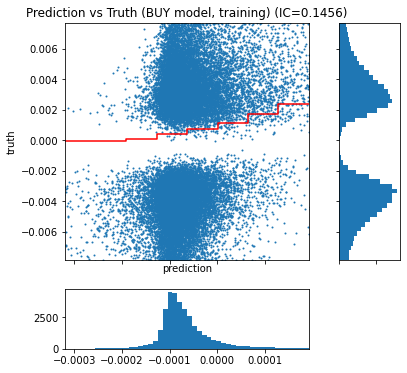

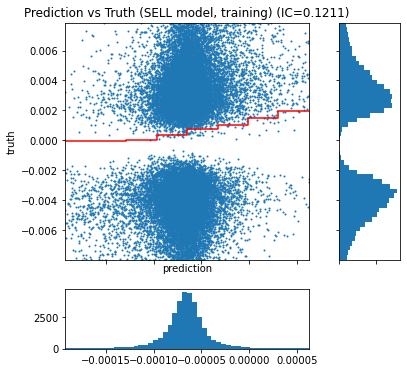

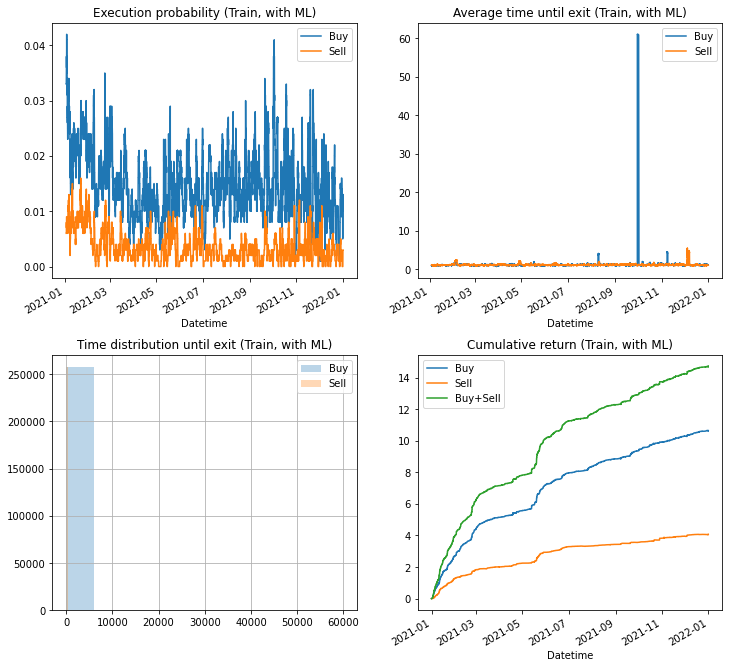

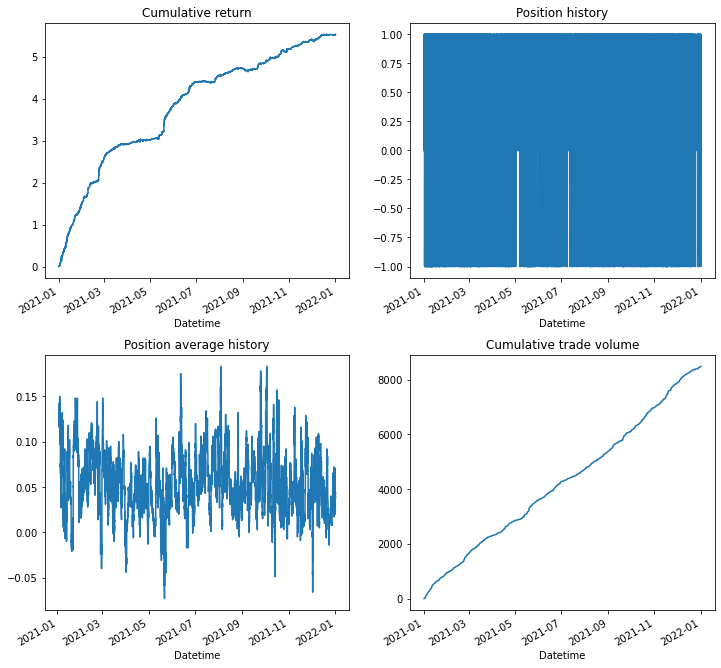

In [10]:
# 学習したモデルに学習区間を予測させて、抽出したパラメータがきちんと働いていることを確認する
# 学習した区間を予測するので、本来の予測性能を表してはいない
df_train['y_pred_buy'] = model_buy.predict(df_train[features], num_iteration=model_buy.best_iteration)
df_train['y_pred_sell'] = model_sell.predict(df_train[features], num_iteration=model_buy.best_iteration)

# 予測が正でない行では取引しないので、buy_executedとsell_executedをすべて0にしておく
df_train.loc[df_train['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_train.loc[df_train['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

display_true_vs_pred(df_train['y_buy'], df_train['y_pred_buy'], 'Prediction vs Truth (BUY model, training)')
display_true_vs_pred(df_train['y_sell'], df_train['y_pred_sell'], 'Prediction vs Truth (SELL model, training)')

# パフォーマンスの表示 (一応)
display_performance(df_train, 'Train, with ML')
display_backtest(df_train)

/tmp/ipykernel_3073192/3495082627.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_range)
/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_3073192/3495082627.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

バーの数 22505本
買いリターン合計 -1.15% 売りリターン合計 3.67% 合計リターン 2.52%
買い 279回, 売り 57回
リターンが正の買い 144回 (51.61 %), リターンが負の買い 135回 (48.39 %)
リターンが正の売り 36回 (63.16 %), リターンが負の売り 21回 (36.84 %)
正の買いリターン平均 0.404 %, 負の買いリターン平均 -0.439 %
正の売りリターン平均 0.351 %, 負の売りリターン平均 -0.426 %
買いリターン平均 -0.004 %, 売りリターン平均 0.064 %


/tmp/ipykernel_3073192/1597318740.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cum_ret'], df['poss'] = backtest(


t test
t value 0.5421381984800578
p value 0.293864337037776
p平均法 n = 5
p平均 0.3947452186292793


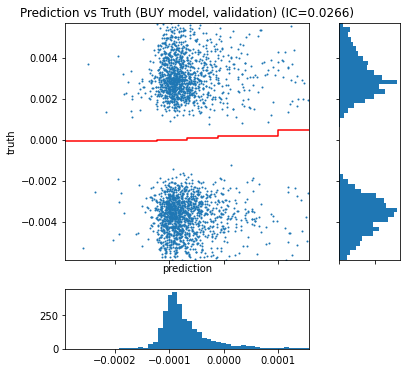

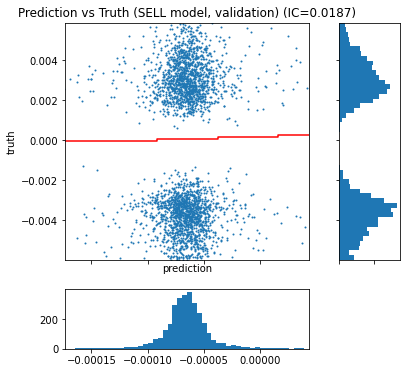

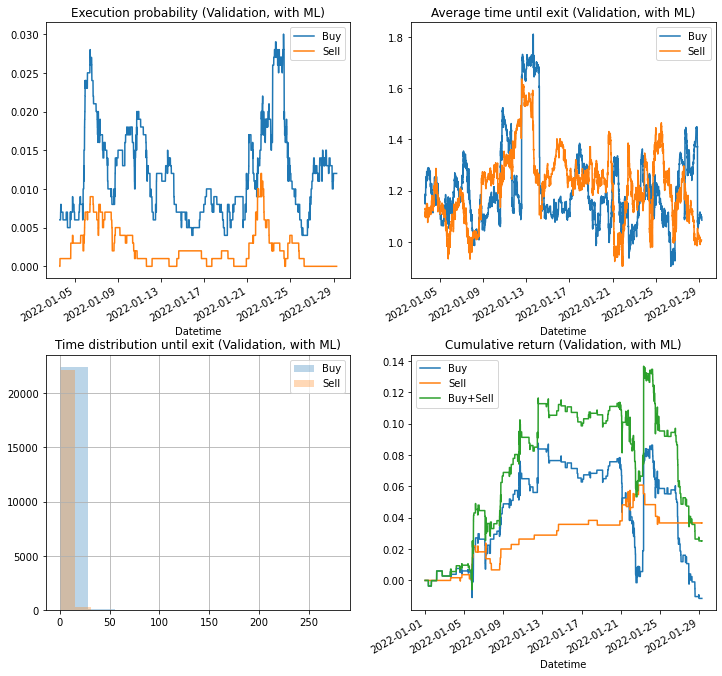

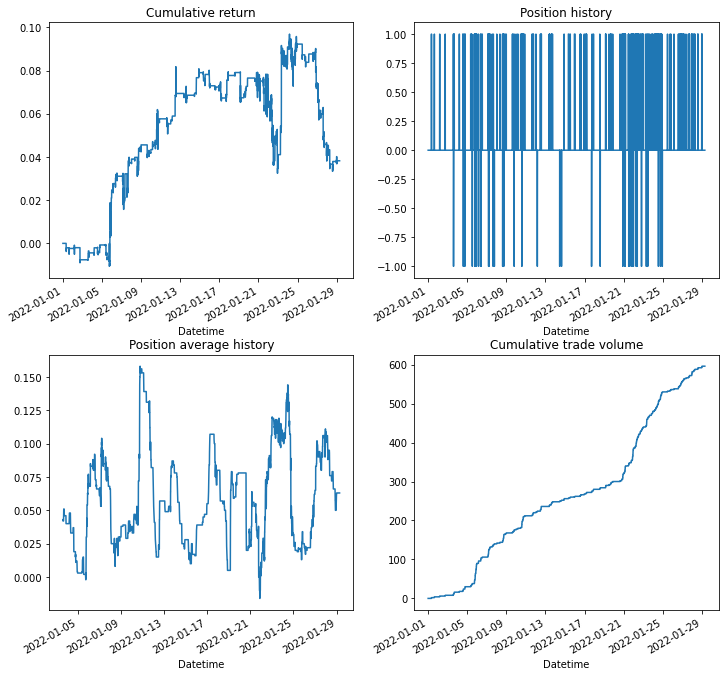

In [15]:
# テスト区間 (今はバリデーション区間と被っている) のデータに売買アクションと特徴量を追加
df_test = df[(df.index >= '2022-01-01 00:00:00+00') & (df.index < '2023-01-01 00:00:00+00')].copy()
df_test = calc_features(df_validation)
df_test = calc_buysell_ptsl(df_test, pips = 1, atr_mux = atr_mux, atr_range = atr_range)
#df_test = calc_buysell(df_test, pips = 1, atr_mux = atr_mux, atr_range = atr_range)

df_test.loc[:, 'y_pred_buy'] = model_buy.predict(df_test[features], num_iteration=model_buy.best_iteration)
df_test.loc[:, 'y_pred_sell'] = model_sell.predict(df_test[features], num_iteration=model_sell.best_iteration)

# 予測が正でないフレームのbuy_executedをすべて0にしておく
df_test.loc[df_test['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_test.loc[df_test['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

# テスト区間でのリターンの真値とリターンの予測値を散布図で比較する
display_true_vs_pred(df_test['y_buy'], df_test['y_pred_buy'], 'Prediction vs Truth (BUY model, validation)')
display_true_vs_pred(df_test['y_sell'], df_test['y_pred_sell'], 'Prediction vs Truth (SELL model, validation)')

# パフォーマンスの表示
display_performance(df_test, 'Validation, with ML')
display_backtest(df_test)

<AxesSubplot:title={'center':'Feature importance (SELL model)'}, xlabel='Feature importance', ylabel='Features'>

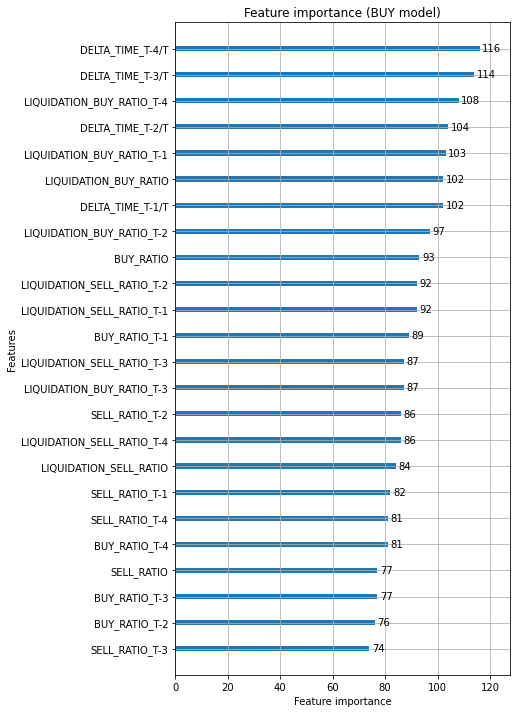

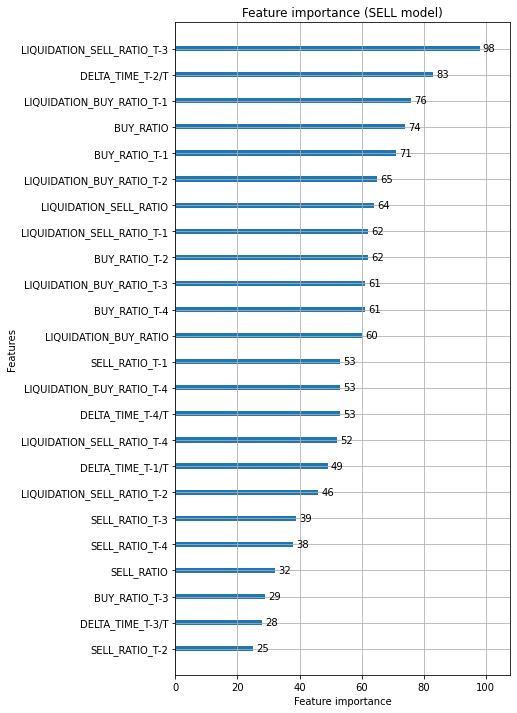

In [12]:
# 特徴量の重要度を表示する
lgb.plot_importance(model_buy, title='Feature importance (BUY model)', figsize=(6, 12))
lgb.plot_importance(model_sell, title='Feature importance (SELL model)', figsize=(6, 12))

In [ ]:
# RichmanbtcさんのCV部分にOptunaの最適化を入れたもの。それぞれのCVでパラメータ最適化をかけるので、かなり時間がかかる

# データフレームをロード
df = pd.read_pickle('df_ohlcv.pkl')

# トレーニングデータに売買アクションと特徴量を追加
df_cv = df[(df.index >= '2021-01-01 00:00:00+00') & (df.index < '2023-01-01 00:00:00+00')].copy()
df_cv = calc_features(df_cv)
df_cv = calc_buysell_ptsl(df_cv, pips = 1, atr_mux = atr_mux, atr_range = atr_range).dropna()
#df_cv = calc_buysell(df_cv, pips = 1, atr_mux = atr_mux, atr_range = atr_range).dropna()

# 通常のCV
cv_indicies = list(KFold(5).split(df_cv))

# OOS予測値を計算
def my_cross_val_predict(X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        # トレーニングデータをLightGBMで使う形式に変換
        train_dataset = lgb.Dataset(X[train_idx], y[train_idx], free_raw_data=False)
        validation_dataset = lgb.Dataset(X[val_idx], y[val_idx], reference=train_dataset, free_raw_data=False)
        
        # OptunaでのLightGBM最適学習パラメータ探索
        model = lgb.train(params,
                          train_dataset,
                          valid_sets=[validation_dataset],
                          early_stopping_rounds = 100,
                          verbose_eval = 0,
                          show_progress_bar = False,
                          optuna_seed = 47)
        y_pred[val_idx] = model.predict(X[val_idx])
    return y_pred

df_cv['y_pred_buy'] = my_cross_val_predict(df_cv[features].values, df_cv['y_buy'].values, cv=cv_indicies)
df_cv['y_pred_sell'] = my_cross_val_predict(df_cv[features].values, df_cv['y_sell'].values, cv=cv_indicies)

バーの数 280288本
買いリターン合計 59.69% 売りリターン合計 -0.58% 合計リターン 59.10%
買い 2235回, 売り 479回
リターンが正の買い 1228回 (54.94 %), リターンが負の買い 1007回 (45.06 %)
リターンが正の売り 255回 (53.24 %), リターンが負の売り 224回 (46.76 %)
正の買いリターン平均 0.457 %, 負の買いリターン平均 -0.498 %
正の売りリターン平均 0.545 %, 負の売りリターン平均 -0.623 %
買いリターン平均 0.027 %, 売りリターン平均 -0.001 %
t test
t value 0.29843549192922797
p value 0.38268551254700944
p平均法 n = 5
p平均 0.5473573140504072


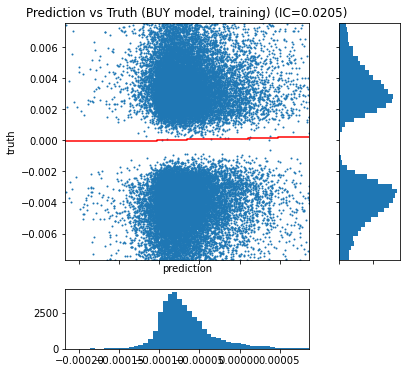

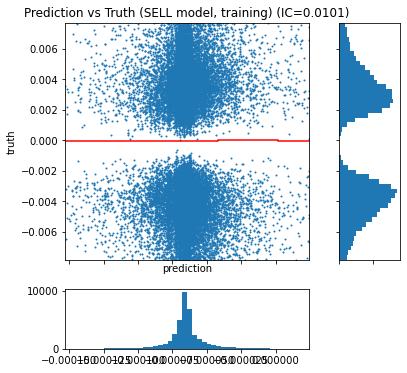

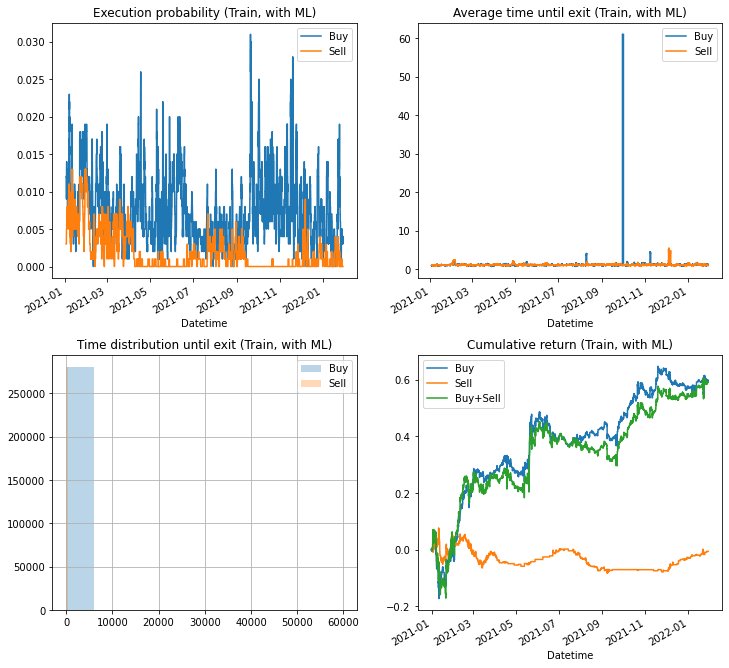

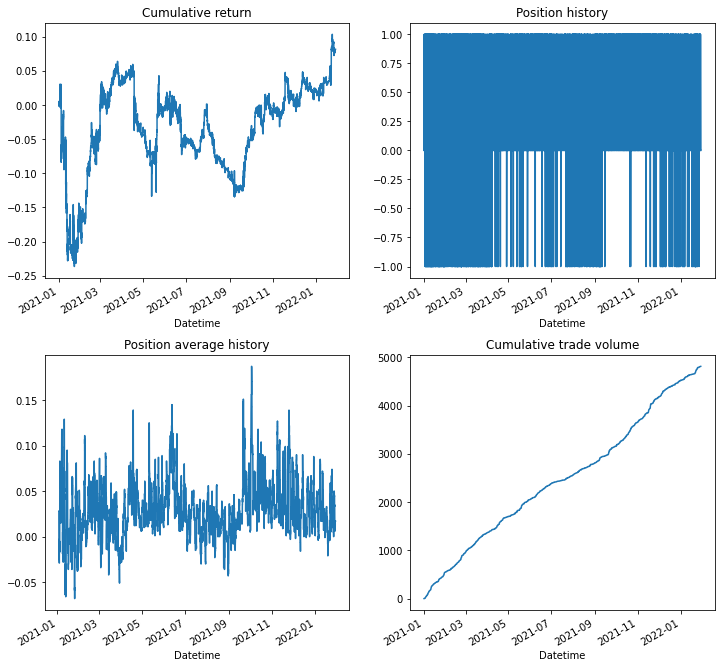

In [14]:
# 予測が正でない行では取引しないので、buy_executedとsell_executedをすべて0にしておく
df_cv.loc[df_cv['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_cv.loc[df_cv['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

display_true_vs_pred(df_cv['y_buy'], df_cv['y_pred_buy'], 'Prediction vs Truth (BUY model, training)')
display_true_vs_pred(df_cv['y_sell'], df_cv['y_pred_sell'], 'Prediction vs Truth (SELL model, training)')

# パフォーマンスの表示 (一応)
display_performance(df_cv, 'Train, with ML')
display_backtest(df_cv)